In [23]:
import plotly.express as px
import pandas as pd
import numpy as np

In [24]:
# Load populations
scenarios = ["baseline", "projection", "s1", "s2", "s3", "s4"]
scenarios = ["s1", "s2", "s3", "s4"]

df_population = []

for scenario in scenarios:
    df_partial = pd.read_csv("output/scenarios/idf_1pct_{}_persons.csv".format(scenario), sep = ";", usecols = [
        "persona", "persona_household_size", "persona_number_of_cars", "persona_location_type"
    ])

    df_partial["scenario"] = scenario
    df_population.append(df_partial)

df_population = pd.concat(df_population)

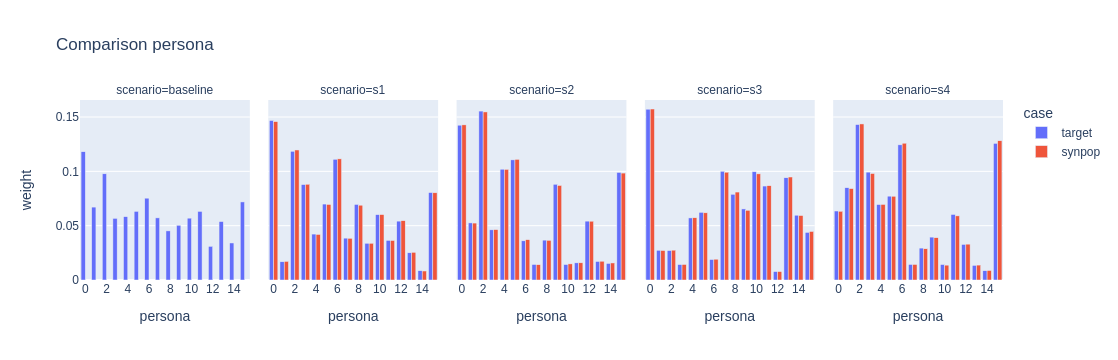

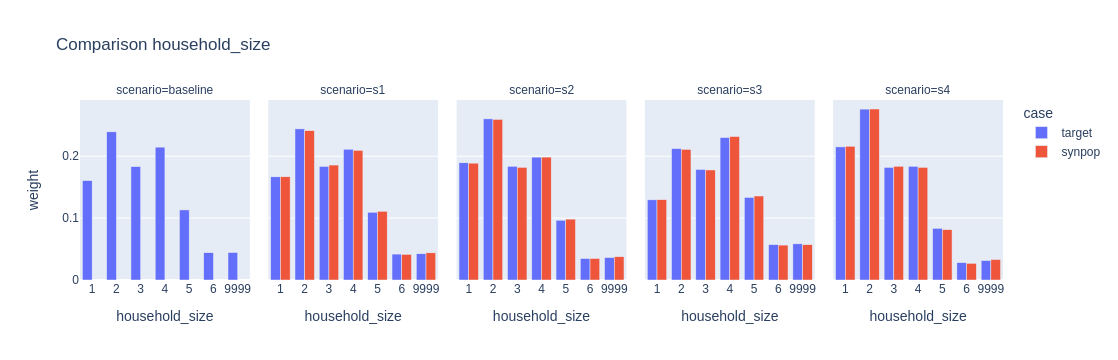

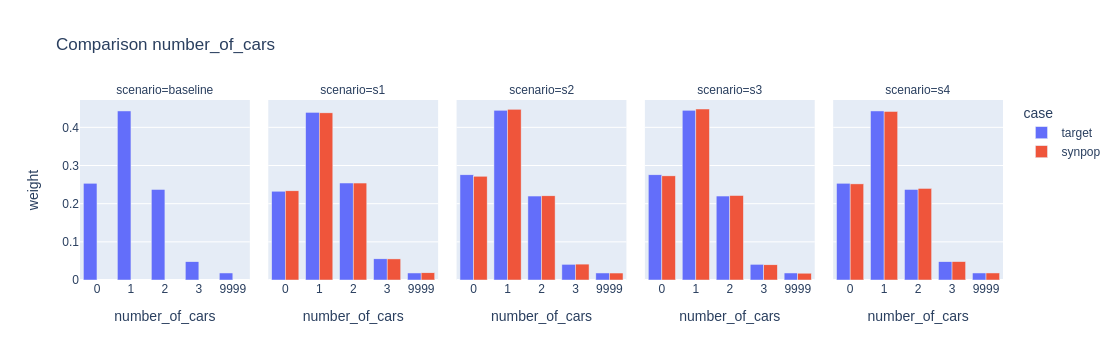

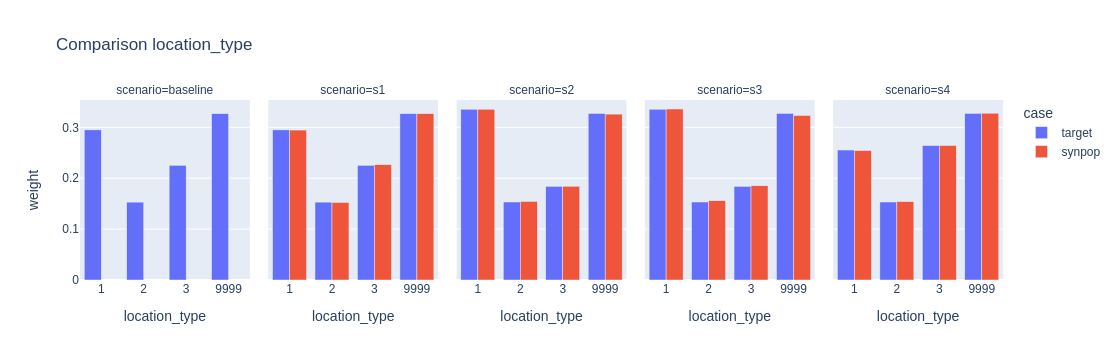

In [27]:
for slot in ["persona", "household_size", "number_of_cars", "location_type"]:
    df_target = pd.read_parquet("output/distribution_{}.parquet".format(slot))
    df_target["scenario"] = df_target["scenario"].str.lower()
    df_target["case"] = "target"

    df_total = df_target.groupby("scenario")["weight"].sum().reset_index(name = "total")
    df_target = pd.merge(df_target, df_total, on = "scenario")
    df_target["weight"] = df_target["weight"] / df_target["total"]
    
    column = "persona_{}".format(slot) if slot != "persona" else "persona"
    df_marginal = df_population.groupby(["scenario", column]).size().reset_index(name = "weight")
    df_marginal["scenario"] = df_marginal["scenario"].str.lower()
    df_marginal = df_marginal.rename(columns = { column: slot })
    df_marginal["case"] = "synpop"

    df_total = df_marginal.groupby("scenario")["weight"].sum().reset_index(name = "total")
    df_marginal = pd.merge(df_marginal, df_total, on = "scenario")
    df_marginal["weight"] = df_marginal["weight"] / df_marginal["total"]

    df_plot = pd.concat([df_target, df_marginal])
    df_plot = df_plot.sort_values(by = ["scenario", slot])
    df_plot[slot] = df_plot[slot].astype(str)

    figure = px.bar(df_plot, x = slot, y = "weight", color = "case", facet_col = "scenario", barmode = "group",
        title = "Comparison {}".format(slot))
    figure.show()